In [26]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
from mlxtend.frequent_patterns import apriori
import pyfpgrowth
from format_rules import format_rules
from server_association import server_association
#from apyori import apriori 

In [43]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
import random
from mlxtend.frequent_patterns import apriori
import pyfpgrowth
from io import BytesIO

#load data
#df=pd.read_csv('/home/natalie/Documents/Manifold/df_test.csv')
client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()), low_memory=False)


df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")


In [42]:
#create a pair column, which is a touple of the src and dst IP, sorted. 
#It does not matter which call came first, we simply want to know which pair occurs most frequently.

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])
#create a normalized latency column = duration/packets
df['norm_latency']=df['Duration']/df['Packets']

TypeError: unsupported operand type(s) for /: 'float' and 'str'

In [41]:
def convert_si_to_number(x):
    total_stars = 0
    if 'k' in x:
        if len(x) > 1:
            total_stars = float(x.replace('k', '')) * 1000 # convert k to a thousand
    elif 'M' in x:
        if len(x) > 1:
            total_stars = float(x.replace('M', '')) * 1000000 # convert M to a million
    elif 'B' in x:
        total_stars = float(x.replace('B', '')) * 1000000000 # convert B to a Billion
    else:
        total_stars = int(x) # Less than 1000
    return int(total_stars)

In [9]:
df.Bytes=df.Bytes.astype('str')
test_list=df.Bytes

[i for i, s in enumerate(test_list) if 'M' in s]#show where the M errors are happening

test_list= [convert_si_to_number(x) for x in test_list]
df.Bytes=test_list #bring it back into the dataframe


In [38]:
df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02


## Implement Frequent Pattern (FP) - Growth algorithm

https://fp-growth.readthedocs.io/en/latest/usage.html

This algorithm
1. Counts occurence of items in dataset in 1st pass
2. Build FP-tree by inserting instances, and adds count to each instance based on the number of times it appears in the dataset. Those infrequent instances are dropped from the tree.

This allows the frequentest set to be generated organically, instead of creating a list of each itemset and checking if it does/does not pass minimum threshold (like Apriori algorithm)

#### Vocabulary
 - itemset = all items in 1 transaction
A "pattern" is a conjunction of items, or the unique itemset.
A "rule" X --> Y means if you buy X you are likely to buy Y, or in this case if X IP address is used Y IP address is likely also


#### Evaluation metrics include:

1. Support = how frequently it occurs. The number of transactions of that unique itemset / all transactions. In this case: number of times IP pair occurs/all requests

2. Confidence = how often rule is likely to be true. frequency of X and Y occuring/ frequency of X occuring in entire dataset. Conditional probability of Y given X. P(Ey|Ex)

3. Lift = How likely is item Y given item X occurs, controlling for how frequent Y occurs in the entire dataset. For rule X-->Y, lift = P(Y|X)/P(Y).
    Lift = 1 means X and Y are independent
    Lift >1 = X and Y are positively correlated
    Lift <1 = X and Y are negatively correlated

### 1. Data manipulation

The fp-growth function requires the data be a list of lists, where each list is an individual "transaction" or in our case IP pair request

In [10]:
#we only want a list of all the individual pairs at each timestamp. Think of this where each timestamp is a 'transaction' and we chose to buy which 2 items (IP addresses)
data_l=list(df['pairs'])
 #this list contains each transaction or timestamp, where many itemsets are repeated

## 2. Implement Frequentest paterns algorithm

Before we run this algorithm, we should have some idea of the minimum threshold we want to set. This is the "support" for each IP pair. Support = % of time this pair occurs in dataset.

In [25]:
#group the dataset by unique pairs, then count how frequently each pair occurs, and also get the average normalized latency time for that pair. The latency times vary because the servers they are assigned are random.
pairs_count=(df.groupby('pairs2').agg({'Date':'count', 'norm_latency': 'mean', 'Duration': 'sum', 'Packets':'sum'}).reset_index())

pairs_count.columns=['pairs','frequency', 'avg_norm_latency', 'total_duration', 'total_packets']
pairs_count['norm_latency']=(pairs_count['total_duration']/pairs_count['total_packets'].sum())*100 #sum of all duration time divided by sum of all packets transfered for that pair

In [12]:
pairs_count.head()

,pairs,frequency,avg_norm_latency,total_duration,total_packets,norm_latency
0,"(0.0.0.0, 255.255.255.255)",123,0.018820,6.801,223,0.000004
1,"(10000_163, 192.168.220.47)",16,0.026500,6.378,204,0.000003
2,"(10000_34, 192.168.210.45)",96,0.022706,23.679,723,0.000013
3,"(10000_34, 192.168.210.46)",165,0.014315,28.699,971,0.000016
4,"(10000_34, 192.168.210.47)",433,0.020122,77.542,1739,0.000042


In [9]:
#df[ (df['Src_IP']=='192.168.210.55')& (df['Dst_IP']=='192.168.100.11')]
#select 1 pair to see how it changes through time

Text(0,0.5,'Frequency of occurance')

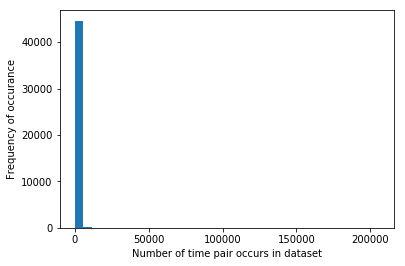

In [10]:
plt.hist(pairs_count['frequency'], bins=35)
plt.xlabel('Number of time pair occurs in dataset')
plt.ylabel('Frequency of occurance')

Whew, this dataset is varied! We definitely want our minimum threshold to be below 200,000 (min=200,000)

Are the pairs that occur frequently likely to have higher or lower latency?

Text(0.5,0,'IP pair frequency of occurance')

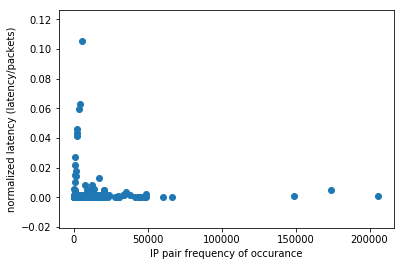

In [11]:
plt.scatter(pairs_count['frequency'], pairs_count['norm_latency'])
plt.ylabel('normalized latency (latency/packets)')
plt.xlabel('IP pair frequency of occurance')
#plt.ylim(-0.001, 0.02)

### We will pick a very low min threshold so many rules are created

Then, we can filter though the rules based on these values and see how many rules would have been created if we had selected a more stringent threshold.


In [13]:
per_20=np.percentile(pairs_count['frequency'], [20])[0] #the value that represents the 20th percentile for frequency of pairs occuring. the 20th percentile is the value (or score) below which 20% of the observations (how frequently a pair occurs) may be found.  
per_40=np.percentile(pairs_count['frequency'], [40])[0]
per_60=np.percentile(pairs_count['frequency'], [60])[0]
per_80=np.percentile(pairs_count['frequency'], [80])[0]


In [14]:
patterns = pyfpgrowth.find_frequent_patterns(data_l, per_80) 
#we set the min threshold of frequency occurance equal to the 80th percentile of frequency, this will only return results where the pair exists above the 80th percentile, a relatively small amount.
#this has to be a whole number and is dependent on the dataset size, thus picking a percentile helps us know what that number means.

In [15]:
per_80/len(df) #this pair occurs this % in the dataset, this is the value Apriori would use for it's min threshold

1.5392147952257956e-05

In [33]:
confidence=0.7 #this means the rule is likely to be true 20% of the time, it is a high threshold, used for testing
rules = pyfpgrowth.generate_association_rules(patterns, confidence)

In [34]:
len(patterns)

11015

### Generate Rules from the most frequent items we found

Bring in the frequency of each rule and sum of the normalized latency. Use these metrics to prioritize the rules we will implement. There is always a tradeoff withh implementing more rules, so we want to be efficient.

In [ ]:
#the input 'rules' is the result of the pyfgrowth function run above. You must have specified the thresholds you want to use
#the orig_df is the original data, with 
#the apps_server is the number of apps that can fit on a server

In [37]:
df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02


In [36]:
rules_df_80per_70con=format_rules(rules, df, 20) #this function was loaded above from the format_rules.py file, 
#the input is the rules and the original dataframe correctly formatted, and the number of apps that can fit on a serveer


KeyError: 'pairs2'

In [35]:
rules_df_80per_70con.head()

,IP_A,IP_B,confidence,pairs,pairs2,frequency,avg_norm_latency,total_duration,total_packets,norm_latency,latency_rank,pair_ID,server_A,server_B,server
326,13053_118,192.168.210.56,1.0,"[13053_118, 192.168.210.56]","(13053_118, 192.168.210.56)",12439,0.255143,15736.067,44427,0.008610,107.096797,0,0,0,0
299,13049_193,192.168.210.56,1.0,"[13049_193, 192.168.210.56]","(13049_193, 192.168.210.56)",1775,0.372031,79345.558,245786,0.043413,77.057656,1,None,None,0
317,13053_106,192.168.210.56,1.0,"[13053_106, 192.168.210.56]","(13053_106, 192.168.210.56)",7180,0.343261,14717.209,31305,0.008052,57.815558,2,None,None,0
322,10272_44,192.168.220.51,1.0,"[10272_44, 192.168.220.51]","(10272_44, 192.168.220.51)",10094,0.091117,3665.353,26275,0.002005,20.242956,3,None,None,0
319,14170_51,192.168.220.51,1.0,"[14170_51, 192.168.220.51]","(14170_51, 192.168.220.51)",8094,0.022052,1881.134,26460,0.001029,8.330628,4,None,None,0


Simple ranking approach:
    Multiply the pair frequency of occurance by the normal latency duration time for that pair. We are simply giving higher priority to pairs that are slow, so even if they are not that frequent they will still be ranked higher because we have more to gain by co-locating them and reducing latency. 
    
    for example if pair A appears 100 times, and has a normal latency of 0.005 it's score = 100*0.005 = 0.5
    if a pair B appears 100 times, and has a normal latency of 0.02, it's score = 100/0.02 = 2.0
    
    Pair B is given a higher score (rank) than Pair A, even though they both had the same frequency, pair B is prioritized because it is slow and costs us time and money. Let's get them co-located!

## Assign Servers to each IP address in the rules dataframe

Start with the highest rank IP pair, assign matching servers and then move on to the next highest rank pair until that server is full. This is a 'dumb' approach, but  it clearly assigns things based on priority and gets a proof of concept. Because IP addresses repeat throughout the rules dataset, we will remove repeated IPs leaving the highest ranked IP.

For this exercise we assume a server can hold 20 apps, or 10 pairs

### Create the final table that lists each IP address in the rules, and the corresponding server it should be assigned to.

All values in IP_A are unique. We do have repeats in IP_B, so need to deal with those.

Rules for assigning servers:
    1. start with the highest ranked pair, assign each of these IPs to server '0'
    2. go to next highest pair, check if IP_B exists in any other server, 
        If it does not, then this pair (IP_A and IP_B) can be assigned to the first server that has room. 
        IF IP_B has already been assigned, put IP_A in the current server. This is not perfect, ideally we would find the server IP_B is already in and put the matching IP_A there, but hard to keep track if that server is full.

In [20]:
server_assignments80, total_latency, total_latency80, avg_latency, avg_latency80 = server_association(rules_df_80per_70con, df, 20) #this function loaded from server_assocation.py file



/home/ubuntu/notebook/Manifold/server_association.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_servers['duration_pred'][df_servers['Src_Server']==df_servers['Dst_Server']]=0


In [22]:
server_assignments80.head()

,IP,serverid
10001_210,10001_210,9.0
10003_106,10003_106,7.0
10003_162,10003_162,7.0
10003_235,10003_235,10.0
10003_51,10003_51,7.0


How did this model do?

In [23]:
total_latency #original total latency

2014119.5810000007

In [24]:
total_latency80 #predicted latency, does not match the other output.... what is wrong...

2013215.9050000007

### Optimization, let's think about the minumum thresholds we are using, how does our model change with different values? Can we optimize the number of rules we implement?

In [19]:
patterns_40=pyfpgrowth.find_frequent_patterns(data_l, per_40)
patterns_80 = pyfpgrowth.find_frequent_patterns(data_l, per_80) 

In [134]:
#check different confidences

con_list=[0.4, 0.6, 0.8]

rules_20per_list=[]
for i in con_list:
    rules_20per_list.append(pyfpgrowth.generate_association_rules(patterns_20, i))
    

rules_df_20per_list=[]
for i in range(len(rules_20per_list)):
    rules_df_20per_list.append(format_rules(rules_20per_list[i], df, 20))
    
total_latency_20=[]

for i in range(len(rules_df_20per_list)):
    result=server_association(rules_df_20per_list[i], 20)[1]
    total_latency_20.append(result) 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [135]:
#check different confidences

con_list=[0.4, 0.6, 0.8]

rules_40per_list=[]
for i in con_list:
    rules_40per_list.append(pyfpgrowth.generate_association_rules(patterns_40, i))
    

rules_df_40per_list=[]
for i in range(len(rules_40per_list)):
    rules_df_40per_list.append(format_rules(rules_40per_list[i], df, 20))
    
total_latency_40=[]

for i in range(len(rules_df_40per_list)):
    result=server_association(rules_df_40per_list[i], 20)[1]
    total_latency_40.append(result)    

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [136]:
con_list=[0.4, 0.6, 0.8]

rules_80per_list=[]
for i in con_list:
    rules_80per_list.append(pyfpgrowth.generate_association_rules(patterns_80, i))
    

rules_df_80per_list=[]
for i in range(len(rules_80per_list)):
    rules_df_80per_list.append(format_rules(rules_80per_list[i], df, 20))
    
total_latency_80=[]

for i in range(len(rules_df_80per_list)):
    result=server_association(rules_df_80per_list[i], 20)[1]
    total_latency_80.append(result)   

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [137]:
#all results are on support = 20th percentile
# 40%, 60%, and 80% confidence rules
total_latency_20

[2013803.1620000002, 2013803.1620000002, 2013803.1620000002]

In [138]:
total_latency_40
#all results are on support = 40th percentile
# 40%, 60%, and 80% confidence

[2013731.6239999996, 2013731.6239999996, 2013731.6239999996]

In [139]:
total_latency_80

[2013215.9050000007, 2013215.9050000007, 2013233.3590000006]

In [122]:
all_latency=total_latency_20+total_latency_40+total_latency_80

In [123]:
rules_matrix=pd.DataFrame(all_latency)

In [125]:
rules_matrix['support']=[20,20,20,40,40,40,80,80,80]
rules_matrix['confidence']=con_list*3

In [126]:
rules_matrix

,0,support,confidence
0,2013803.162,20,0.4
1,2013803.162,20,0.6
2,2013803.162,20,0.8
3,2013731.624,40,0.4
4,2013731.624,40,0.6
5,2013731.624,40,0.8
6,2013215.905,80,0.4
7,2013215.905,80,0.6
8,2013233.359,80,0.8


In [111]:
server_association(rules_df_40per_list[0], 20)[1]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2013731.6239999996

In [109]:
len(rules_df_40per_list[0])

2060

In [112]:
len(rules_df_40per_list[1])

1833

In [113]:
server_association(rules_df_40per_list[1], 20)[1]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2013731.6239999996

In [73]:
rules_40per_20con= pyfpgrowth.generate_association_rules(patterns_40, confidence)
rules_40per_50con= pyfpgrowth.generate_association_rules(patterns_40, 0.5)
rules_40per_70con= pyfpgrowth.generate_association_rules(patterns_40, 0.7)
rules_df_40per_20con=format_rules(rules_40per_20con, df, 20)
rules_df_40per_50con=format_rules(rules_40per_50con, df, 20)
rules_df_40per_70con=format_rules(rules_40per_70con, df, 20)

rules_80per_20con= pyfpgrowth.generate_association_rules(patterns_80, confidence)
rules_80per_50con= pyfpgrowth.generate_association_rules(patterns_80, 0.5)
rules_80per_70con= pyfpgrowth.generate_association_rules(patterns_80, 0.7)
rules_df_80per_20con=format_rules(rules_80per_20con, df, 20)
rules_df_80per_50con=format_rules(rules_80per_50con, df, 20)
rules_df_80per_70con=format_rules(rules_80per_70con, df, 20)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
#change dictionary to df so we can export
patterns_20_df=pd.DataFrame.from_dict(patterns_20, orient='index')
patterns_20_df['IP']=patterns_20_df.index

patterns_40_df=pd.DataFrame.from_dict(patterns_40, orient='index')
patterns_40_df['IP']=patterns_40_df.index

patterns_80_df=pd.DataFrame.from_dict(patterns_80, orient='index')
patterns_80_df['IP']=patterns_80_df.index

In [62]:
rules_20per_20con_df=pd.DataFrame.from_dict(rules_20per_20con, orient='index', columns=['IP_B', 'confidence'])
rules_40per_20con_df=pd.DataFrame.from_dict(rules_40per_20con, orient='index' ,columns=['IP_B', 'confidence'])
rules_80per_20con_df=pd.DataFrame.from_dict(rules_80per_20con, orient='index', columns=['IP_B', 'confidence'])

rules_20per_20con_df['IP_A']=rules_20per_20con_df.index
rules_40per_20con_df['IP_A']=rules_40per_20con_df.index
rules_80per_20con_df['IP_A']=rules_80per_20con_df.index

In [63]:
#write these patters to csv in case we want them again
patterns_20_df.to_csv("patterns_20_20con.csv")
patterns_40_df.to_csv("patterns_40_20con.csv")
patterns_80_df.to_csv("patterns_80_20con.csv")

rules_20per_20con_df.to_csv("rules_20per_20con.csv")
rules_40per_20con_df.to_csv("rules_40per_20con.csv")
rules_80per_20con_df.to_csv("rules_80per_20con.csv")


In [ ]:
rules_80per_20con_df

In [56]:
total_latency_20per_20con = server_association(rules_df_20per_20con, 20)[1]
total_latency_40per_20con = server_association(rules_df_40per_20con, 20)[1]
total_latency_80per_20con = server_association(rules_df_80per_20con, 20)[1]



/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [114]:
total_latency_40per_50con = server_association(rules_df_40per_50con, 20)[1]
total_latency_40per_70con = server_association(rules_df_80per_50con, 20)[1]
total_latency_80per_50con = server_association(rules_df_80per_50con, 20)[1]
total_latency_80per_70con = server_association(rules_df_80per_70con, 20)[1]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
total_latency_20per_20con

2013801.5270000005

In [58]:
total_latency_40per_20con

2013726.5759999992

In [115]:
total_latency_80per_20con

2013217.8660000006

In [116]:
total_latency_80per_50con

2013215.9050000007

In [117]:
total_latency_80per_70con

2013215.9050000007

In [155]:
rules_df_20sup_20con=format_rules(rules_20per_20con, df, 20) #largest df
#Now if I want to create other dataframes where the min support threshold were different, this is the same as filtering by frequency
rules_df_40sup_20con=rules_df_20sup_20con[rules_df_20sup_20con.frequency >= per_40] #
rules_df_60sup_20con=rules_df_20sup_20con[rules_df_20sup_20con.frequency >= per_60]
rules_df_80sup_20con=rules_df_20sup_20con[rules_df_20sup_20con.frequency >= per_60] #smallest df, b/c having frequency above the 80th percentile is less common that the 20th percentile

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
type(rules_df_20sup_20con)

NameError: name 'rules_df_20sup_20con' is not defined

In [145]:
rules_20con=[rules_df_20sup_20con, rules_df_40sup_20con, rules_df_60sup_20con, rules_df_80sup_20con]

In [151]:
server_association(rules_df_20sup_20con, 20)[1]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2013801.5270000005

In [153]:
rules_df_20sup_20con

,IP_A,IP_B,confidence,pairs,pairs2,frequency,avg_norm_latency,total_duration,total_packets,norm_latency,latency_rank,pair_ID,server_A,server_B,server
3068,13053_118,192.168.210.56,1.0,"[13053_118, 192.168.210.56]","(13053_118, 192.168.210.56)",12439,0.255143,15736.067,44427,8.609759e-03,1.070968e+02,0,None,None,0
3057,13049_193,192.168.210.56,1.0,"[13049_193, 192.168.210.56]","(13049_193, 192.168.210.56)",1775,0.372031,79345.558,245786,4.341276e-02,7.705766e+01,1,None,None,0
3062,13053_106,192.168.210.56,1.0,"[13053_106, 192.168.210.56]","(13053_106, 192.168.210.56)",7180,0.343261,14717.209,31305,8.052306e-03,5.781556e+01,2,None,None,0
3066,10272_44,192.168.220.51,1.0,"[10272_44, 192.168.220.51]","(10272_44, 192.168.220.51)",10094,0.091117,3665.353,26275,2.005444e-03,2.024296e+01,3,None,None,0
3064,14170_51,192.168.220.51,1.0,"[14170_51, 192.168.220.51]","(14170_51, 192.168.220.51)",8094,0.022052,1881.134,26460,1.029235e-03,8.330628e+00,4,None,None,0
3065,192.168.100.1,192.168.220.51,1.0,"[192.168.100.1, 192.168.220.51]","(192.168.100.1, 192.168.220.51)",9770,0.022819,1246.609,11053,6.820639e-04,6.663764e+00,5,None,None,0
3067,12087_137,192.168.220.47,1.0,"[12087_137, 192.168.220.47]","(12087_137, 192.168.220.47)",12158,0.010903,547.857,47097,2.997520e-04,3.644384e+00,6,None,None,0
3063,14185_238,192.168.220.51,1.0,"[14185_238, 192.168.220.51]","(14185_238, 192.168.220.51)",8084,0.022407,417.154,9549,2.282397e-04,1.845090e+00,7,None,None,0
3059,11681_180,192.168.210.54,0.9963998305802626,"[11681_180, 192.168.210.54]","(11681_180, 192.168.210.54)",4705,0.022177,685.636,31111,3.751357e-04,1.765014e+00,8,None,None,0
3061,14172_51,192.168.220.51,1.0,"[14172_51, 192.168.220.51]","(14172_51, 192.168.220.51)",6600,0.004654,135.466,11514,7.411824e-05,4.891804e-01,9,None,None,0


In [162]:
rules_df_40sup_20con['IP_B'].iloc[0]

'192.168.210.56'

In [159]:
latency_20sup_20con=server_association(rules_df_20sup_20con, 20)[1]
latency_40sup_20con=(server_association(rules_df_40sup_20con, 20)[1])
latency_60sup_20con=(server_association(rules_df_60sup_20con, 20)[1])
latency_80sup_20con=(server_association(rules_df_80sup_20con, 20)[1])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


KeyError: 0